# Predictive Maintenance

Contributors: michaelmenzel@

# Setup

In [ ]:
project_id = "sandbox-michael-menzel" #@param {type:"string"}

In [ ]:
#@title Grant Permissions to your GCP Project & Import Dependencies
!gcloud config set core/project $project_id
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!pip install --quiet facets-overview lifelines google-cloud-automl ipython-autotime
%load_ext autotime
%load_ext google.colab.data_table

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Introduce facets
from IPython.core.display import display, HTML
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64
import uuid

def facets_overview(df):
    gfsg = GenericFeatureStatisticsGenerator()
    proto = gfsg.ProtoFromDataFrames([{'name': 'df', 'table': df}])
    protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
            <facets-overview id="facets-overview-{uuid}"></facets-overview>
            <script>
              document.querySelector("#facets-overview-{uuid}").protoInput = "{protostr}";
            </script>"""

    html = HTML_TEMPLATE.format(protostr=protostr, uuid=uuid.uuid4())
    display(HTML(html))

def facets_dive(df): 
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
            <facets-dive id="facets-dive-{uuid}" height="500"></facets-dive>
            <script>
              document.querySelector("#facets-dive-{uuid}").data = {jsonstr};
            </script>"""

    jsonstr = df.to_json(orient='records')
    html = HTML_TEMPLATE.format(jsonstr=jsonstr, uuid=uuid.uuid4())
    display(HTML(html))

Updated property [core/project].
Authenticated
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
time: 6.07 s


# Data Preparation

We use the BigQuery public dataset on traffic safety which incorporate a large number of traffic accidents. Based on an accident, we can calculate the total lifetime of a car being on the road. 

Nonetheless, the example of course car lifetime has a misrepresentation of car longevity over the whole timeline. Old cars will potentially survive longer as they had more time to accrue lifetime. This unfair advantage is not accounted for in the following evaluation and models using the data. 

In [ ]:
%%bigquery df --project $project_id
SELECT 
  CONCAT(vehicle.L_YEAR, '-', vehicle.ST_CASE, '/', vehicle.VEH_NO) as id, 
--  accident.YEAR as end_year,
--  IF(vehicle.MOD_YEAR < 100, CAST(CONCAT("19", IF(vehicle.MOD_YEAR < 10, CONCAT("0",vehicle.MOD_YEAR), CAST(vehicle.MOD_YEAR AS STRING))) AS NUMERIC), vehicle.MOD_YEAR) as start_year,
  accident.YEAR - IF(vehicle.MOD_YEAR < 100, CAST(CONCAT("19", IF(vehicle.MOD_YEAR < 10, CONCAT("0",vehicle.MOD_YEAR), CAST(vehicle.MOD_YEAR AS STRING))) AS NUMERIC), vehicle.MOD_YEAR) as survival_age,
  1 AS event,
  vehicle.BODY_TYP as vehicle_type,
  vehicle.MAKE as vehicle_brand
FROM `dataflix-public-datasets.traffic_safety.vehicle` as vehicle, `dataflix-public-datasets.traffic_safety.accident` as accident
WHERE vehicle.ST_CASE = accident.ST_CASE 
  AND vehicle.L_YEAR = accident.L_YEAR
  AND IF(vehicle.MOD_YEAR < 100, CAST(CONCAT("19", IF(vehicle.MOD_YEAR < 10, CONCAT("0",vehicle.MOD_YEAR), CAST(vehicle.MOD_YEAR AS STRING))) AS NUMERIC), vehicle.MOD_YEAR) BETWEEN 1900 AND EXTRACT(YEAR FROM CURRENT_TIMESTAMP())
  AND IF(vehicle.MOD_YEAR < 100, CAST(CONCAT("19", IF(vehicle.MOD_YEAR < 10, CONCAT("0",vehicle.MOD_YEAR), CAST(vehicle.MOD_YEAR AS STRING))) AS NUMERIC), vehicle.MOD_YEAR) <= accident.YEAR
  AND vehicle.DEFORMED = "Disabling Damage"
ORDER BY survival_age DESC
LIMIT 100000

time: 12.8 s


In [ ]:
dataset = df.loc[df.survival_age > 0].drop(['id'], axis=1)
dataset.survival_age = dataset.survival_age.astype('int')
dataset.vehicle_type = dataset.vehicle_type.astype('category').cat.codes
dataset.vehicle_brand = dataset.vehicle_brand.astype('category').cat.codes

T = dataset.survival_age
E = dataset.event

time: 136 ms


# Exploratory Data Analysis

In [ ]:
dataset.describe()

,survival_age,event,vehicle_type,vehicle_brand
count,100000.000000,100000.0,100000.000000,100000.000000
mean,23.039970,1.0,25.106200,32.002070
std,6.568084,0.0,23.373284,21.804355
min,18.000000,1.0,0.000000,0.000000
25%,19.000000,1.0,4.000000,12.000000
50%,21.000000,1.0,14.000000,23.000000
75%,24.000000,1.0,48.000000,49.000000
max,99.000000,1.0,88.000000,82.000000


time: 49.8 ms


In [ ]:
facets_overview(dataset)

time: 1.85 s


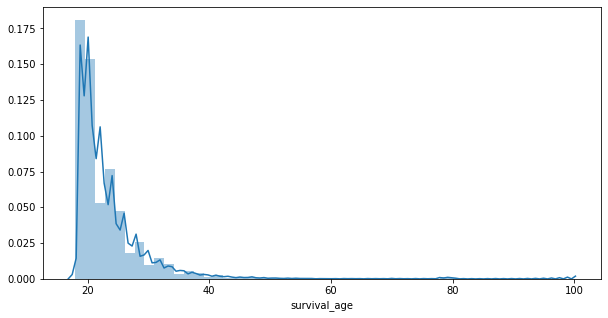

time: 296 ms


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(dataset.survival_age)

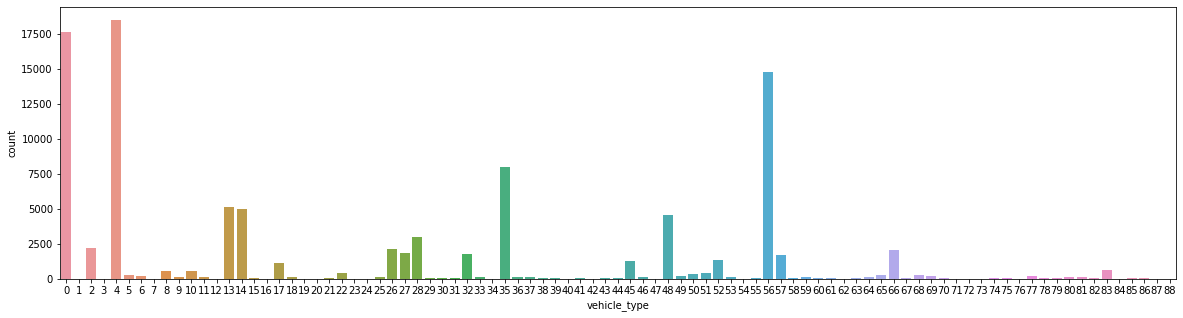

time: 1.05 s


In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(dataset.vehicle_type)

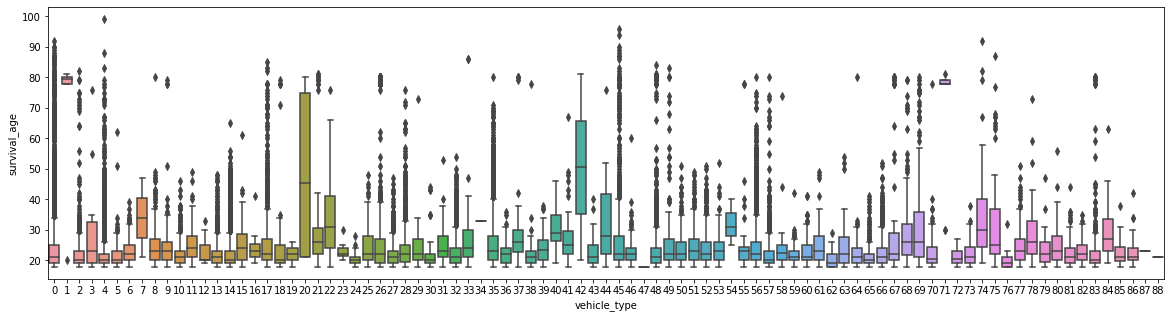

time: 1.93 s


In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x=dataset.vehicle_type, y=dataset.survival_age)

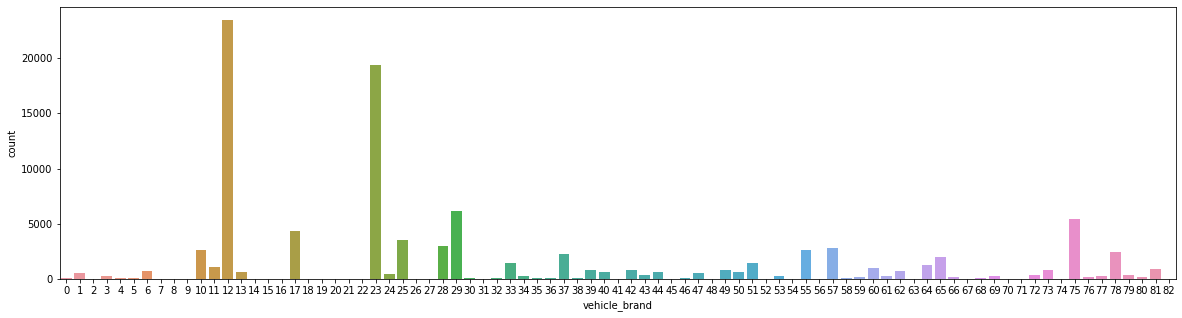

time: 965 ms


In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(dataset.vehicle_brand)

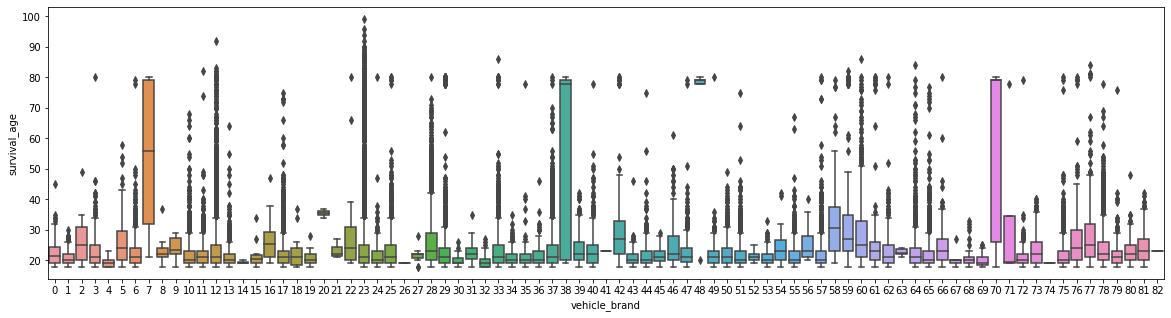

time: 1.83 s


In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x=dataset.vehicle_brand, y=dataset.survival_age)

# Clustering

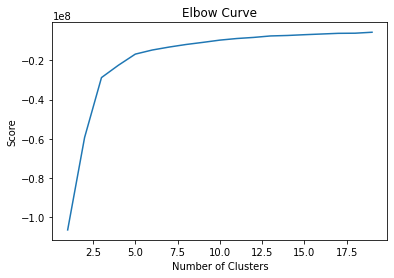

time: 51.2 s


In [ ]:
from sklearn.cluster import KMeans

n = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in n]
score = [kmeans[i].fit(dataset).score(dataset) for i in range(len(kmeans))]
plt.plot(n,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

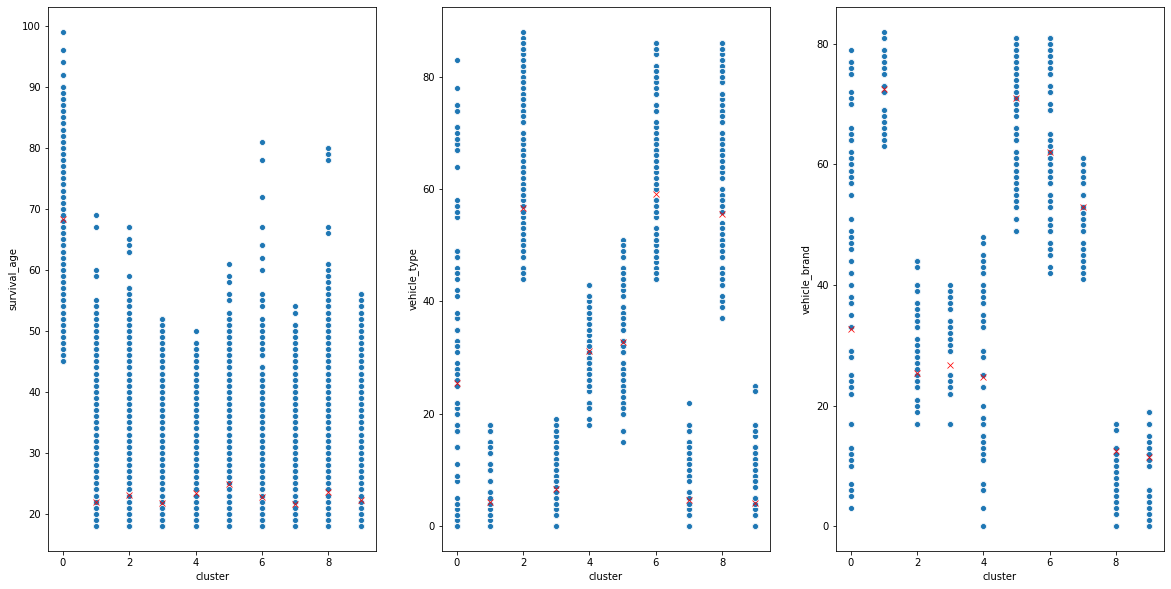

time: 3.7 s


In [ ]:
kmeans = KMeans(n_clusters=10).fit(dataset)
y_kmeans = kmeans.predict(dataset)
centers = kmeans.cluster_centers_
dataset['cluster'] = kmeans.labels_


fig, axes = plt.subplots(1,3, figsize=(20, 10))
for column, ax  in zip(dataset.drop(['cluster', 'event'], axis=1).columns, axes.flat):
  sns.scatterplot(dataset.cluster, dataset[column], ax=ax)
  sns.scatterplot(range(0, centers.shape[0]), centers[:,dataset.columns.get_loc(column)], marker="x", color='r', ax=ax)
plt.show()

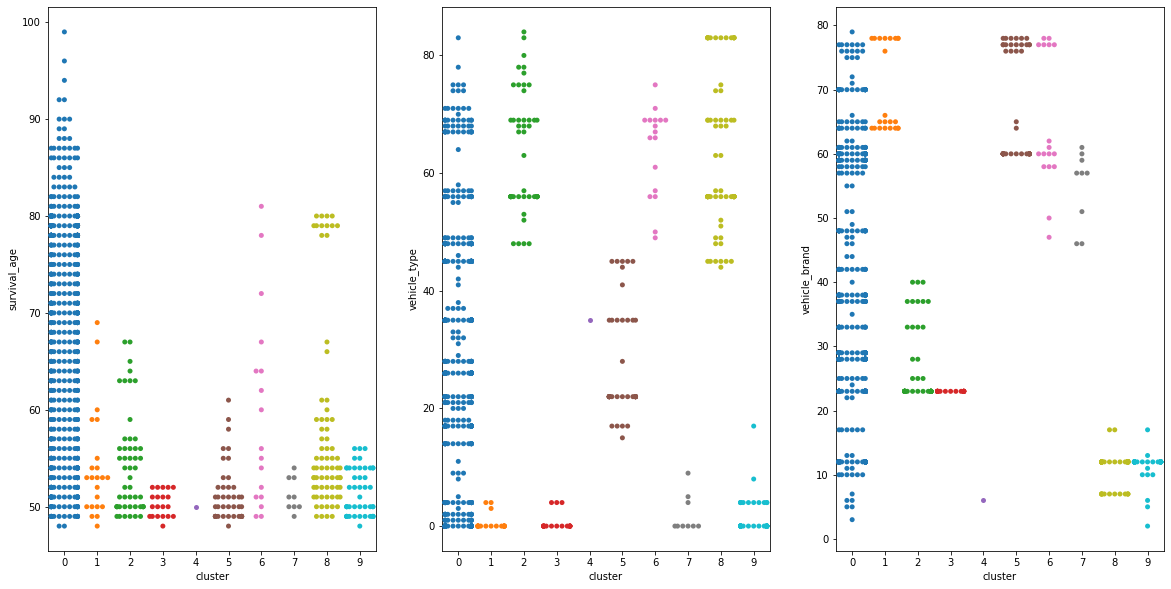

time: 4.22 s


In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20, 10))

dataset_plot = dataset[:1000]
for column, ax  in zip(dataset_plot.drop(['cluster', 'event'], axis=1).columns, axes.flat):
  sns.swarmplot(dataset_plot.cluster, dataset_plot[column], ax=ax)
  
plt.show()

# Training Models

## Train univariate survival model

The following models are only taking into account the lifetime of a vehicle.

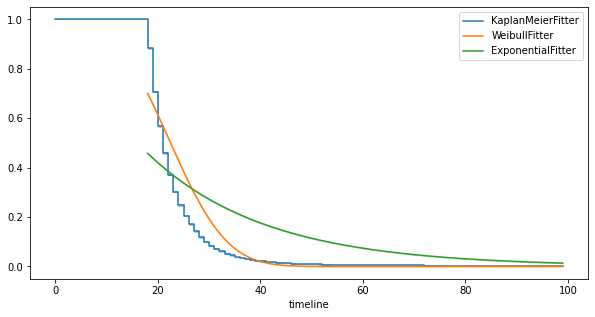

time: 1.27 s


In [ ]:
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter

survivals = [KaplanMeierFitter().fit(T, E, label="KaplanMeierFitter"), 
             WeibullFitter().fit(T, E, label='WeibullFitter'),
             ExponentialFitter().fit(T, E, label='ExponentialFitter')]

plt.figure(figsize=(10,5))
for survival in survivals:
  survival.plot_survival_function()

## Train multivariate survival models based on lifetime

The following models are factoring in additional attributes of a vehicle.

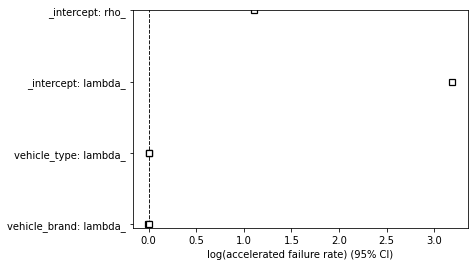

time: 1.53 s


In [ ]:
from lifelines import CoxPHFitter, WeibullAFTFitter, AalenAdditiveFitter

survival_regressions = [CoxPHFitter(), WeibullAFTFitter()]
for survival_reg in survival_regressions:
  survival_reg.fit(dataset, duration_col='survival_age', event_col='event')
  survival_reg.plot()

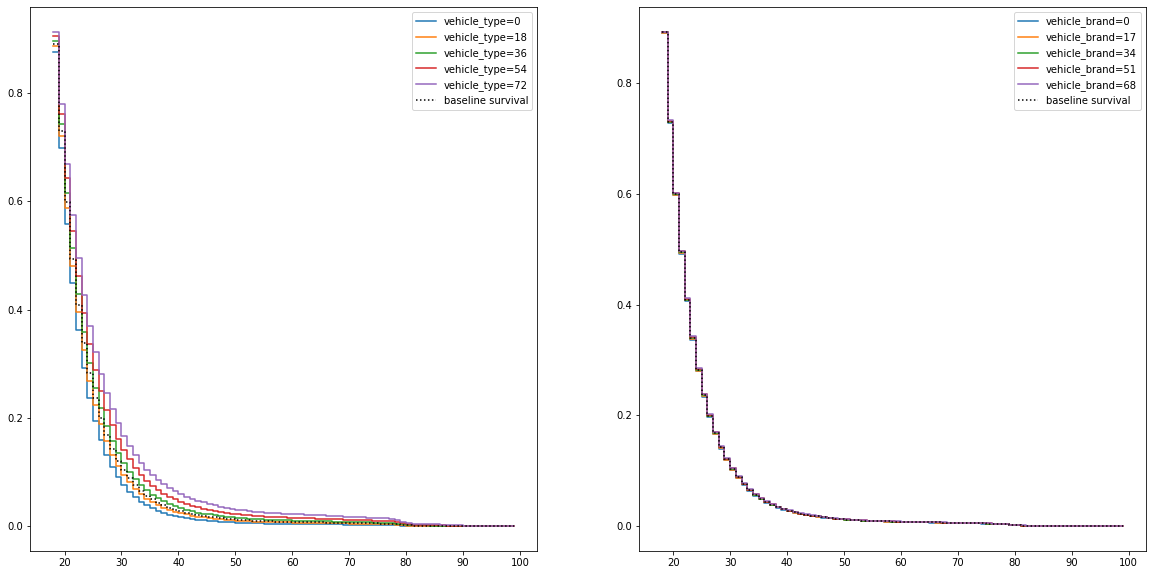

time: 660 ms


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))
for survival_reg in survival_regressions:
  for column, ax in zip(dataset.drop(['event', 'survival_age'], axis=1).columns, axes.flat):
    min = dataset[column].min()
    max = dataset[column].max()
    survival_reg.plot_covariate_groups(column, range(min, max, math.ceil((max-min)/5)), ax=ax)
  plt.show()

# Predictions

## Prediction with an univariate survival model


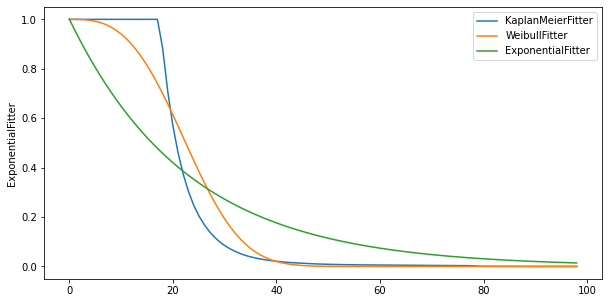

time: 296 ms


In [ ]:
plt.figure(figsize=(10,5))
for survival in survivals:
  predicted = survival.predict(range(math.ceil(T.max())))
  sns.lineplot(predicted.index, predicted, label=predicted.name)

## Prediction with a multivariate survival model


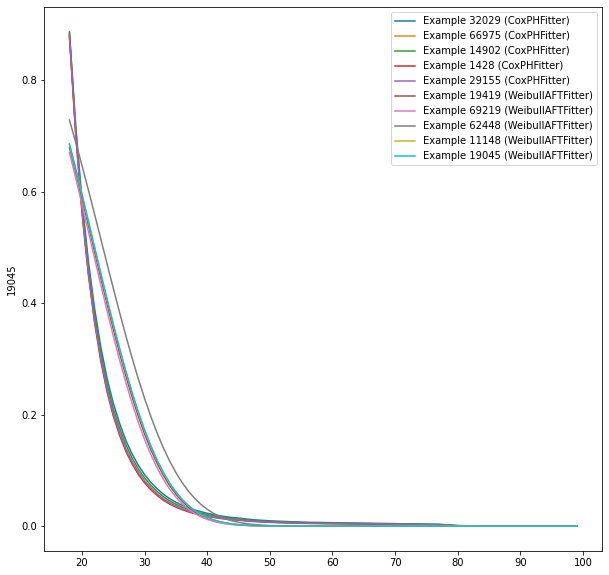

time: 561 ms


In [ ]:
plt.figure(figsize=(10,10))
for survival_reg in survival_regressions:
  predicted = survival_reg.predict_survival_function(dataset.sample(5))
  for column in predicted.columns:
    sns.lineplot(x=predicted.index, y=predicted[column], label=f"Example {column} ({type(survival_reg).__name__})")

# Deep Learning Model

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.2.0-rc3
time: 1.42 s
